In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


# Load the data
df = pd.read_csv(r"C:\Users\souvick\Downloads\Bitcoin - dataset.csv")
df = df.drop(columns=['index'])

sample_size = 1000
df_sample = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
df_sample = df_sample.sort_values('timestamp')

# Display basic info about the sampled data
print(df_sample.head())

           open        high         low       close       volume  \
40    68.749001   74.561096   66.620003   74.561096      0.00000   
681  135.139999  145.809998  134.809998  138.339996      0.00000   
90     2.278340    2.381180    2.205250    2.360280      0.00000   
310    4.013800    4.094780    3.892290    3.981650      0.00000   
814    0.027365    0.027810    0.026814    0.026944  58533.39844   

        marketCap                 timestamp crypto_name        date  
40   8.488390e+08  2013-07-07T23:59:59.999Z     Bitcoin  2013-07-07  
681  1.610215e+09  2013-09-01T23:59:59.999Z     Bitcoin  2013-09-01  
90   5.331587e+07  2013-10-31T23:59:59.999Z    Litecoin  2013-10-31  
310  9.137087e+07  2013-11-12T23:59:59.999Z    Litecoin  2013-11-12  
814  2.106491e+08  2014-01-01T23:59:59.999Z         XRP  2014-01-01  


In [2]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Assume df_sample is a DataFrame that already exists
# Feature Engineering
df_sample['7_day_MA'] = df_sample['close'].rolling(window=7).mean()
df_sample['30_day_MA'] = df_sample['close'].rolling(window=30).mean()
df_sample['price_diff'] = df_sample['close'].diff()
df_sample['volatility'] = (df_sample['high'] - df_sample['low']) / df_sample['open']
df_sample.fillna(0, inplace=True)

# Define features and target
features = ['open', 'high', 'low', 'volume', 'marketCap', '7_day_MA', '30_day_MA', 'price_diff', 'volatility']
target = 'close'

# Scale the data
scaler = MinMaxScaler()
df_sample[features + [target]] = scaler.fit_transform(df_sample[features + [target]])

# Create sequences for LSTM
look_back = 60  # Number of time steps to consider
def create_sequences(data, features, target, look_back=60):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[features].iloc[i-look_back:i].values)
        y.append(data[target].iloc[i])
    return np.array(X), np.array(y)

# Train-test split
train_size = int(len(df_sample) * 0.7)
train_data = df_sample[:train_size]
test_data = df_sample[train_size:]

X_train, y_train = create_sequences(train_data, features, target, look_back)
X_test, y_test = create_sequences(test_data, features, target, look_back)

# Reshape y_train and y_test to make them 2D
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Convert data to float32
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

print("X_train dtype:", X_train.dtype)
print("y_train dtype:", y_train.dtype)


# Output shapes for verification
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train dtype: float32
y_train dtype: float32
X_train shape: (640, 60, 9), y_train shape: (640, 1)
X_test shape: (240, 60, 9), y_test shape: (240, 1)


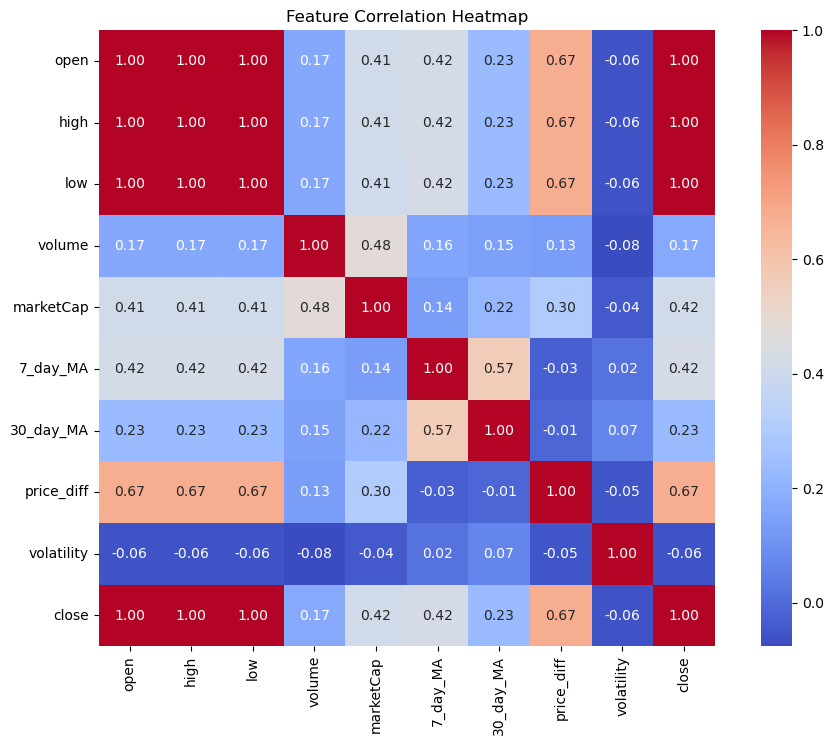

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlations
correlation_matrix = df_sample[features + [target]].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Feature Correlation Heatmap")
plt.show()


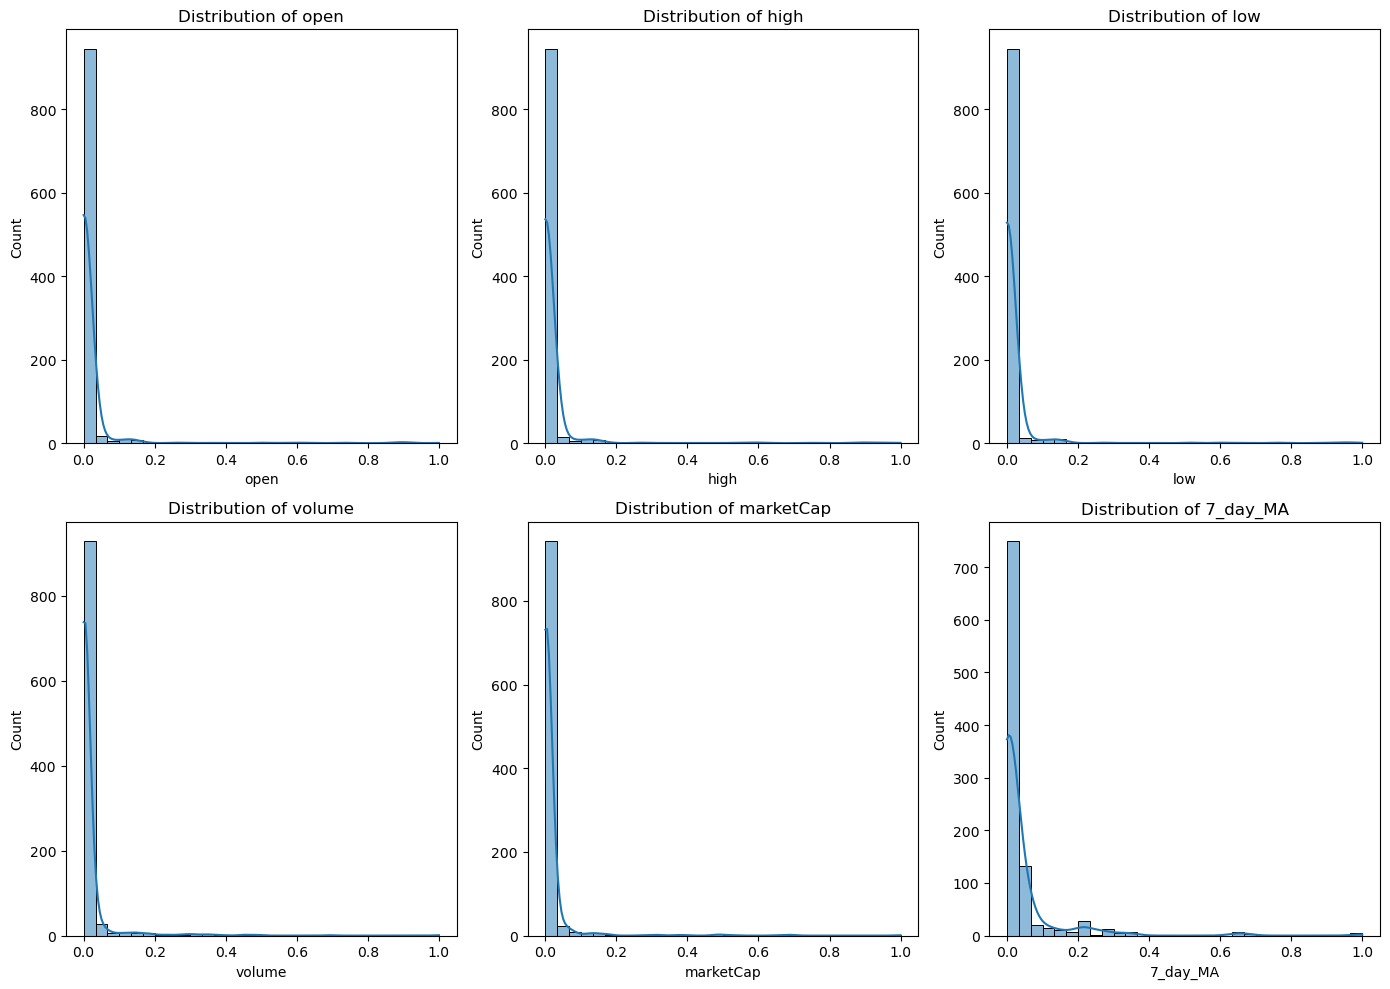

In [4]:
# Plot feature distributions
plt.figure(figsize=(14, 10))
for i, feature in enumerate(features[:6]):  # Visualize first 6 features
    plt.subplot(2, 3, i + 1)
    sns.histplot(df_sample[feature], kde=True, bins=30)
    plt.title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()


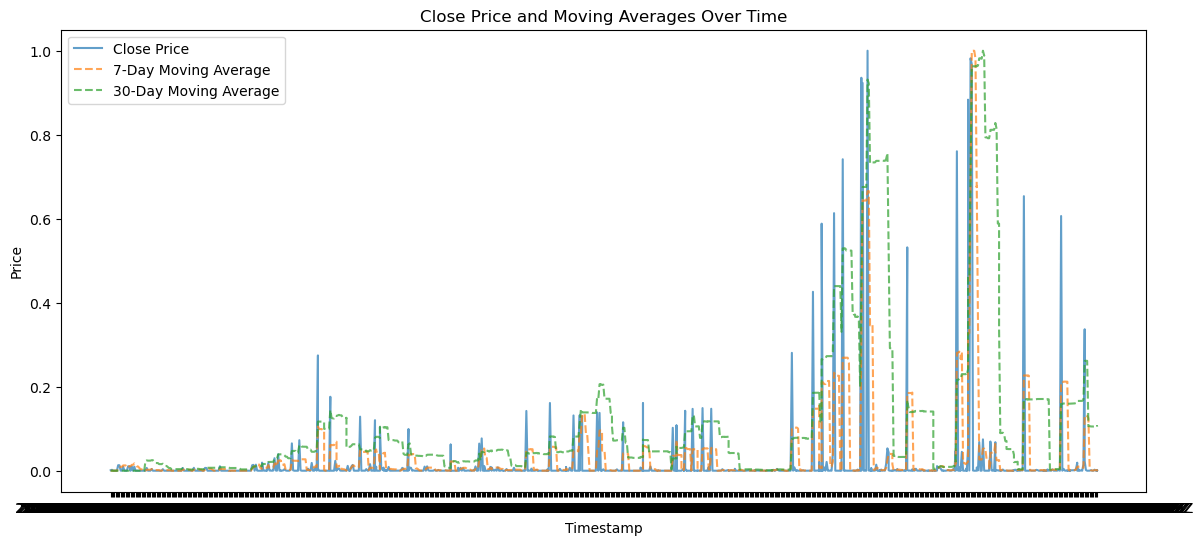

In [5]:
# Plot time-series trends
plt.figure(figsize=(14, 6))
plt.plot(df_sample['timestamp'], df_sample['close'], label="Close Price", alpha=0.7)
plt.plot(df_sample['timestamp'], df_sample['7_day_MA'], label="7-Day Moving Average", linestyle='--', alpha=0.7)
plt.plot(df_sample['timestamp'], df_sample['30_day_MA'], label="30-Day Moving Average", linestyle='--', alpha=0.7)
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.title("Close Price and Moving Averages Over Time")
plt.legend()
plt.show()

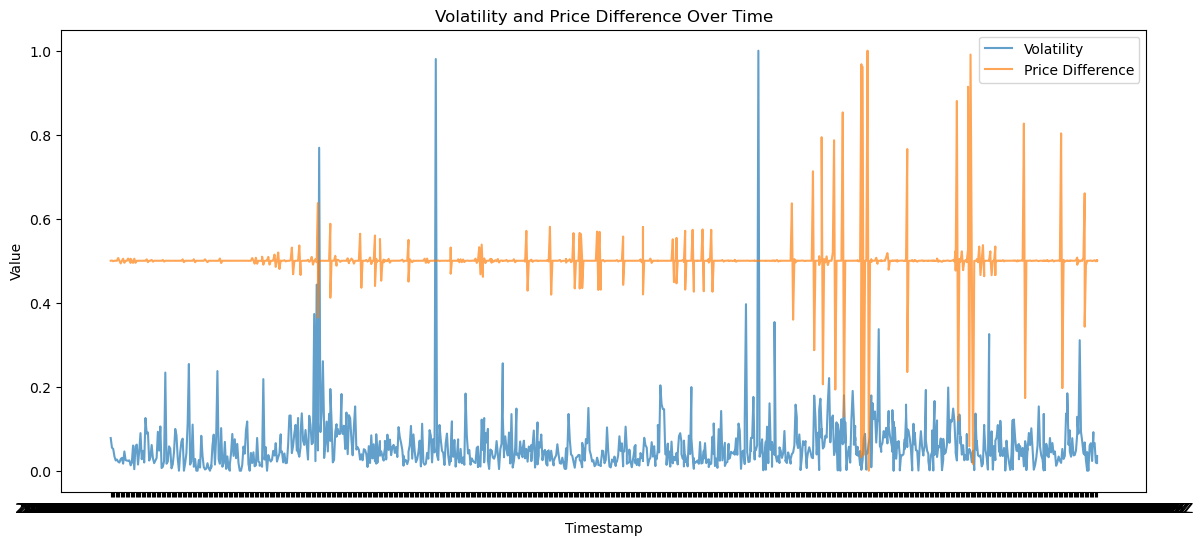

In [6]:
# Plot volatility and price difference
plt.figure(figsize=(14, 6))
plt.plot(df_sample['timestamp'], df_sample['volatility'], label="Volatility", alpha=0.7)
plt.plot(df_sample['timestamp'], df_sample['price_diff'], label="Price Difference", alpha=0.7)
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.title("Volatility and Price Difference Over Time")
plt.legend()
plt.show()

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.optimizers as optimizers

def build_lstm_model(input_shape, num_layers=2, dropout_rate=0.2, units=50):
    """
    Builds an LSTM model with the specified parameters.

    Parameters:
    - input_shape: Shape of the input data (look_back, num_features).
    - num_layers: Number of LSTM layers in the model.
    - dropout_rate: Dropout rate to prevent overfitting.
    - units: Number of LSTM units in each layer.

    Returns:
    - model: Compiled LSTM model.
    """
    model = Sequential()
    for i in range(num_layers):
        return_sequences = i < num_layers - 1  # Return sequences for all but the last LSTM layer
        model.add(LSTM(units=units, return_sequences=return_sequences, input_shape=input_shape if i == 0 else None))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Final dense layer for prediction
    return model


In [8]:
def train_and_evaluate_model(model, optimizer, X_train, y_train, X_test, y_test, epochs=20, batch_size=32):
    """
    Compiles, trains, and evaluates the LSTM model.
    Args:
    - model: The LSTM model.
    - optimizer: Optimizer instance (e.g., Adam, SGD).
    - X_train: Training input data.
    - y_train: Training labels.
    - X_test: Testing input data.
    - y_test: Testing labels.
    - epochs: Number of training epochs.
    - batch_size: Size of training batches.
    
    Returns:
    - model: Trained model.
    - history: Training history containing loss and validation metrics.
    """
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)
    return model, history


In [9]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()


In [10]:
import tensorflow as tf
print("Eager execution enabled:", tf.executing_eagerly())


Eager execution enabled: True


Training model with 1 LSTM layers, 32 units, using Adam optimizer...
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0041 - mae: 0.0463 - val_loss: 0.0213 - val_mae: 0.0514
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0022 - mae: 0.0313 - val_loss: 0.0207 - val_mae: 0.0514
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0026 - mae: 0.0269 - val_loss: 0.0206 - val_mae: 0.0525
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0018 - mae: 0.0247 - val_loss: 0.0202 - val_mae: 0.0506
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0019 - mae: 0.0225 - val_loss: 0.0204 - val_mae: 0.0506
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0021 - mae: 0.0233 - val_loss: 0.0203 - val_mae: 0.0495
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0019 - mae: 0.0219 - val_loss: 0.0203 - val_mae: 0.0490
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0016 - mae: 0.0197 - val_loss: 0.0204 - val_mae: 0.

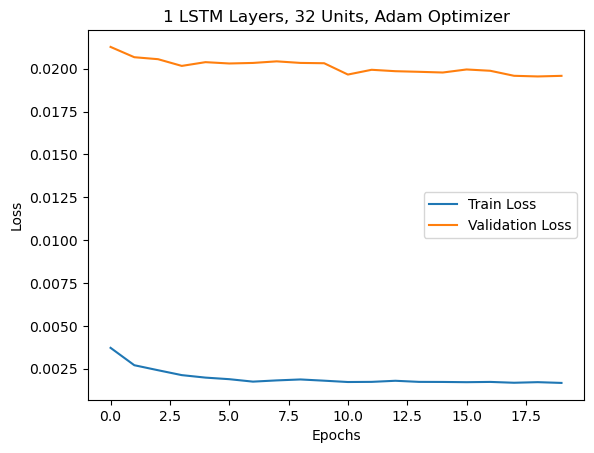

Training model with 1 LSTM layers, 32 units, using RMSprop optimizer...
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0121 - mae: 0.0829 - val_loss: 0.0209 - val_mae: 0.0595
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0035 - mae: 0.0412 - val_loss: 0.0206 - val_mae: 0.0582
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0024 - mae: 0.0332 - val_loss: 0.0207 - val_mae: 0.0645
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0019 - mae: 0.0262 - val_loss: 0.0204 - val_mae: 0.0544
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0021 - mae: 0.0256 - val_loss: 0.0201 - val_mae: 0.0622
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0018 - mae: 0.0243 - val_loss: 0.0198 - val_mae: 0.0537
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0018 - mae: 0.0227 - val_loss: 0.0197 - val_mae: 0.0531
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0013 - mae: 0.0194 - val_loss: 0.0196 - val_mae:

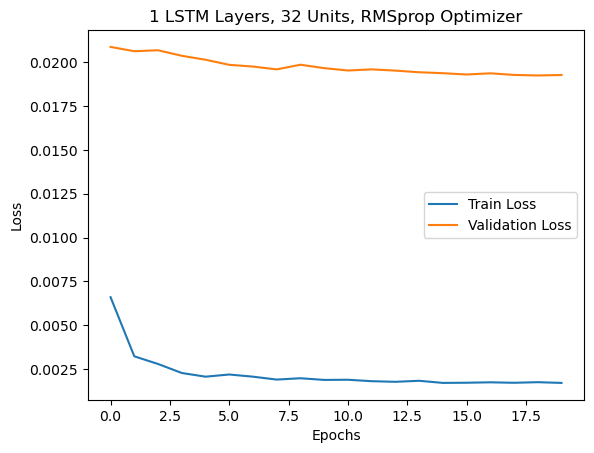

Training model with 1 LSTM layers, 32 units, using SGD optimizer...
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0031 - mae: 0.0429 - val_loss: 0.0229 - val_mae: 0.0699
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0026 - mae: 0.0366 - val_loss: 0.0227 - val_mae: 0.0652
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0025 - mae: 0.0352 - val_loss: 0.0227 - val_mae: 0.0642
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0033 - mae: 0.0353 - val_loss: 0.0227 - val_mae: 0.0640
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0031 - mae: 0.0352 - val_loss: 0.0226 - val_mae: 0.0628
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0036 - mae: 0.0366 - val_loss: 0.0226 - val_mae: 0.0635
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0036 - mae: 0.0369 - val_loss: 0.0226 - val_mae: 0.0625
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0026 - mae: 0.0333 - val_loss: 0.0226 - val_mae: 0.0

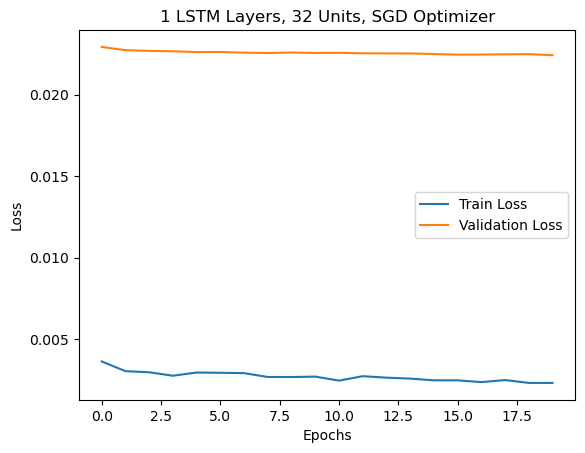

Training model with 1 LSTM layers, 50 units, using Adam optimizer...
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0024 - mae: 0.0342 - val_loss: 0.0182 - val_mae: 0.0464
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0017 - mae: 0.0234 - val_loss: 0.0177 - val_mae: 0.0419
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0016 - mae: 0.0214 - val_loss: 0.0179 - val_mae: 0.0484
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0020 - mae: 0.0225 - val_loss: 0.0186 - val_mae: 0.0456
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0022 - mae: 0.0215 - val_loss: 0.0189 - val_mae: 0.0469
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0022 - mae: 0.0206 - val_loss: 0.0190 - val_mae: 0.0448
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0013 - mae: 0.0165 - val_loss: 0.0187 - val_mae: 0.0519
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0018 - mae: 0.0202 - val_loss: 0.0190 - val_mae: 0.

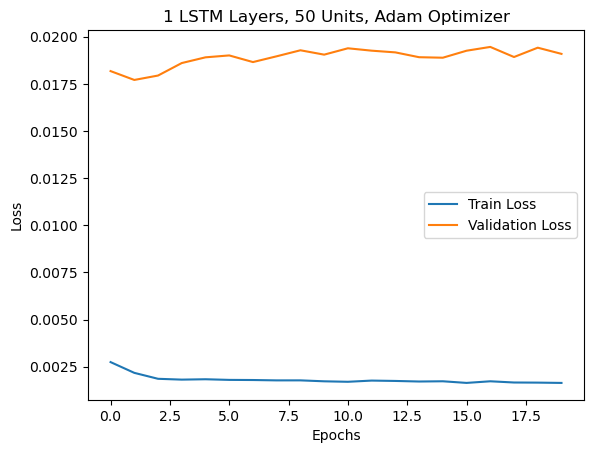

Training model with 1 LSTM layers, 50 units, using RMSprop optimizer...
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0035 - mae: 0.0371 - val_loss: 0.0186 - val_mae: 0.0397
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0033 - mae: 0.0295 - val_loss: 0.0187 - val_mae: 0.0585
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0024 - mae: 0.0263 - val_loss: 0.0186 - val_mae: 0.0425
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0027 - mae: 0.0243 - val_loss: 0.0185 - val_mae: 0.0444
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0017 - mae: 0.0228 - val_loss: 0.0187 - val_mae: 0.0610
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0014 - mae: 0.0242 - val_loss: 0.0187 - val_mae: 0.0389
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0016 - mae: 0.0191 - val_loss: 0.0191 - val_mae: 0.0335
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0031 - mae: 0.0220 - val_loss: 0.0189 - val_mae:

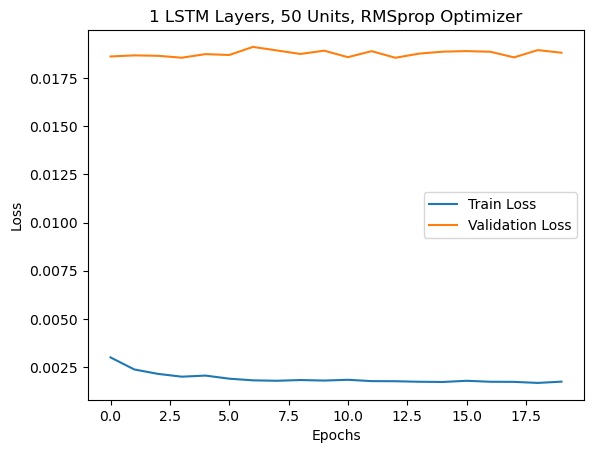

Training model with 1 LSTM layers, 50 units, using SGD optimizer...
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0096 - mae: 0.0859 - val_loss: 0.0197 - val_mae: 0.0455
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0036 - mae: 0.0350 - val_loss: 0.0188 - val_mae: 0.0417
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0035 - mae: 0.0320 - val_loss: 0.0188 - val_mae: 0.0436
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0021 - mae: 0.0279 - val_loss: 0.0187 - val_mae: 0.0461
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0023 - mae: 0.0288 - val_loss: 0.0187 - val_mae: 0.0463
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0023 - mae: 0.0289 - val_loss: 0.0187 - val_mae: 0.0452
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0021 - mae: 0.0265 - val_loss: 0.0187 - val_mae: 0.0464
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0029 - mae: 0.0289 - val_loss: 0.0187 - val_mae: 0.0

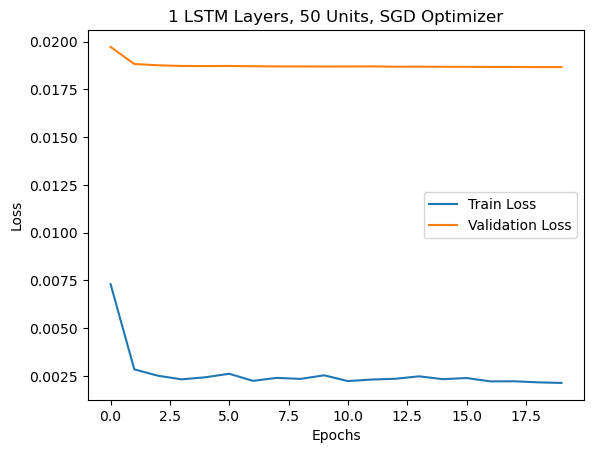

Training model with 1 LSTM layers, 64 units, using Adam optimizer...
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0035 - mae: 0.0401 - val_loss: 0.0190 - val_mae: 0.0401
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0021 - mae: 0.0271 - val_loss: 0.0193 - val_mae: 0.0370
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0017 - mae: 0.0213 - val_loss: 0.0197 - val_mae: 0.0373
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0010 - mae: 0.0173 - val_loss: 0.0192 - val_mae: 0.0398
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0018 - mae: 0.0197 - val_loss: 0.0192 - val_mae: 0.0396
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0016 - mae: 0.0187 - val_loss: 0.0192 - val_mae: 0.0415
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0014 - mae: 0.0156 - val_loss: 0.0195 - val_mae: 0.0445
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0022 - mae: 0.0181 - val_loss: 0.0196 - val_mae: 0.

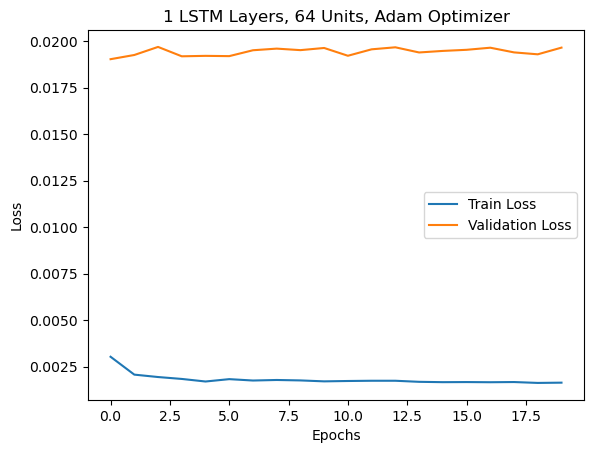

Training model with 1 LSTM layers, 64 units, using RMSprop optimizer...
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0027 - mae: 0.0363 - val_loss: 0.0196 - val_mae: 0.0678
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0024 - mae: 0.0280 - val_loss: 0.0188 - val_mae: 0.0489
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0024 - mae: 0.0238 - val_loss: 0.0188 - val_mae: 0.0426
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0033 - mae: 0.0277 - val_loss: 0.0190 - val_mae: 0.0382
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0011 - mae: 0.0171 - val_loss: 0.0189 - val_mae: 0.0435
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0020 - mae: 0.0218 - val_loss: 0.0189 - val_mae: 0.0463
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0017 - mae: 0.0182 - val_loss: 0.0191 - val_mae: 0.0429
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0015 - mae: 0.0172 - val_loss: 0.0191 - val_mae:

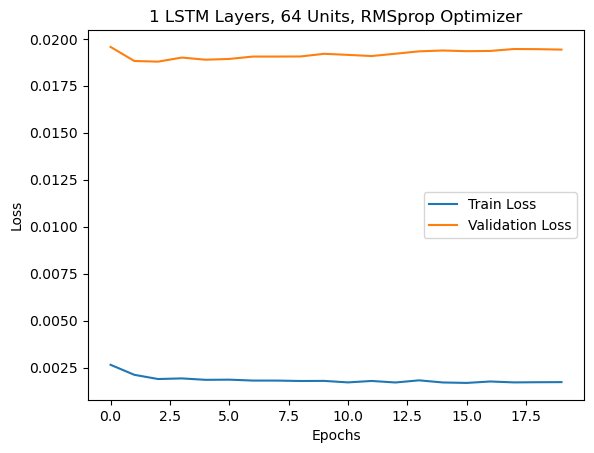

Training model with 1 LSTM layers, 64 units, using SGD optimizer...
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0031 - mae: 0.0318 - val_loss: 0.0176 - val_mae: 0.0371
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0030 - mae: 0.0299 - val_loss: 0.0177 - val_mae: 0.0363
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0021 - mae: 0.0275 - val_loss: 0.0177 - val_mae: 0.0364
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0018 - mae: 0.0277 - val_loss: 0.0177 - val_mae: 0.0366
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0027 - mae: 0.0308 - val_loss: 0.0177 - val_mae: 0.0361
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0030 - mae: 0.0281 - val_loss: 0.0177 - val_mae: 0.0359
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0030 - mae: 0.0321 - val_loss: 0.0177 - val_mae: 0.0358
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0026 - mae: 0.0294 - val_loss: 0.0176 - val_mae: 0.0

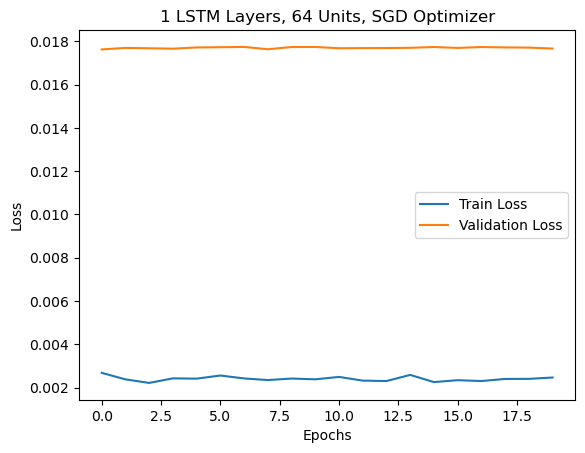

Training model with 2 LSTM layers, 32 units, using Adam optimizer...
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0018 - mae: 0.0275 - val_loss: 0.0187 - val_mae: 0.0389
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0015 - mae: 0.0185 - val_loss: 0.0186 - val_mae: 0.0356
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0018 - mae: 0.0190 - val_loss: 0.0187 - val_mae: 0.0472
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0014 - mae: 0.0173 - val_loss: 0.0186 - val_mae: 0.0416
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0013 - mae: 0.0160 - val_loss: 0.0187 - val_mae: 0.0389
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0015 - mae: 0.0153 - val_loss: 0.0189 - val_mae: 0.0384
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0030 - mae: 0.0188 - val_loss: 0.0189 - val_mae: 0.0419
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0020 - mae: 0.0204 - val_loss: 0.0185 - val_mae: 0.

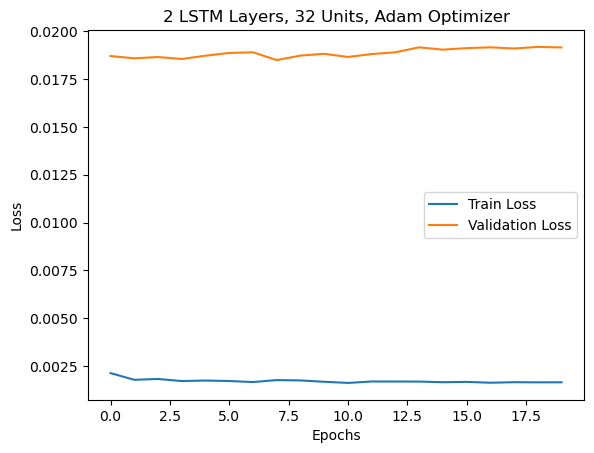

Training model with 2 LSTM layers, 32 units, using RMSprop optimizer...
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0035 - mae: 0.0423 - val_loss: 0.0209 - val_mae: 0.0484
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0027 - mae: 0.0287 - val_loss: 0.0199 - val_mae: 0.0409
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0016 - mae: 0.0209 - val_loss: 0.0189 - val_mae: 0.0323
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0015 - mae: 0.0198 - val_loss: 0.0185 - val_mae: 0.0390
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0024 - mae: 0.0215 - val_loss: 0.0186 - val_mae: 0.0369
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0015 - mae: 0.0173 - val_loss: 0.0185 - val_mae: 0.0377
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0018 - mae: 0.0202 - val_loss: 0.0186 - val_mae: 0.0356
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0016 - mae: 0.0187 - val_loss: 0.0185 - val_mae:

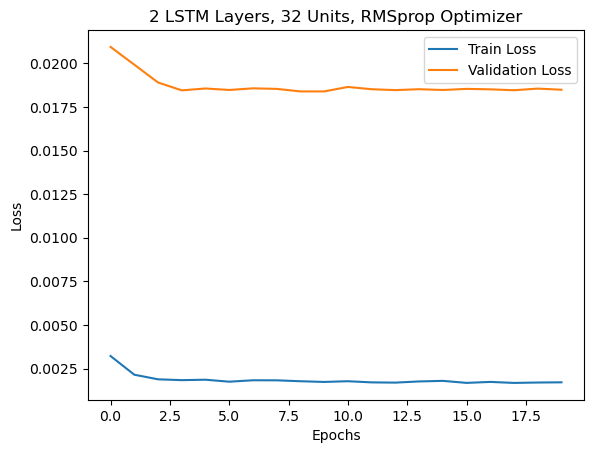

Training model with 2 LSTM layers, 32 units, using SGD optimizer...
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0092 - mae: 0.0832 - val_loss: 0.0197 - val_mae: 0.0555
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0024 - mae: 0.0334 - val_loss: 0.0208 - val_mae: 0.0512
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0034 - mae: 0.0264 - val_loss: 0.0211 - val_mae: 0.0517
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0025 - mae: 0.0251 - val_loss: 0.0210 - val_mae: 0.0515
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0028 - mae: 0.0256 - val_loss: 0.0211 - val_mae: 0.0517
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0018 - mae: 0.0230 - val_loss: 0.0211 - val_mae: 0.0515
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0022 - mae: 0.0241 - val_loss: 0.0211 - val_mae: 0.0515
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0016 - mae: 0.0227 - val_loss: 0.0210 - val_mae: 0.0

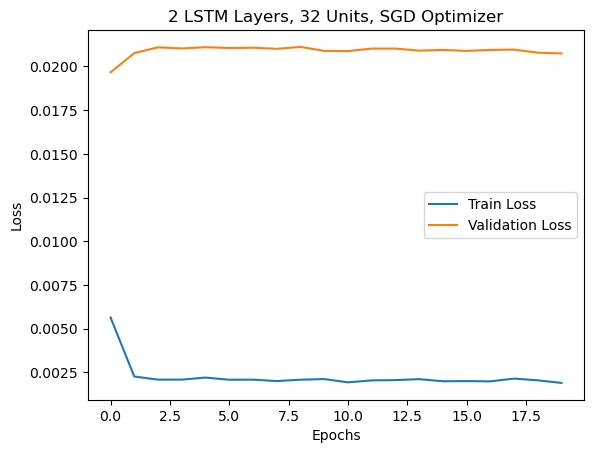

Training model with 2 LSTM layers, 50 units, using Adam optimizer...
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0022 - mae: 0.0283 - val_loss: 0.0184 - val_mae: 0.0366
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0016 - mae: 0.0168 - val_loss: 0.0183 - val_mae: 0.0433
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0011 - mae: 0.0182 - val_loss: 0.0192 - val_mae: 0.0356
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0016 - mae: 0.0191 - val_loss: 0.0188 - val_mae: 0.0358
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0012 - mae: 0.0143 - val_loss: 0.0184 - val_mae: 0.0448
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0020 - mae: 0.0194 - val_loss: 0.0192 - val_mae: 0.0388
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0017 - mae: 0.0157 - val_loss: 0.0190 - val_mae: 0.0417
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0019 - mae: 0.0162 - val_loss: 0.0192 - val_mae: 0.

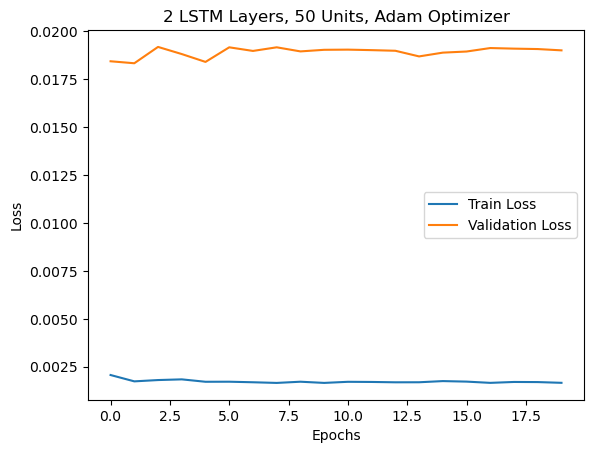

Training model with 2 LSTM layers, 50 units, using RMSprop optimizer...
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0040 - mae: 0.0410 - val_loss: 0.0185 - val_mae: 0.0443
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0019 - mae: 0.0218 - val_loss: 0.0185 - val_mae: 0.0502
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0026 - mae: 0.0232 - val_loss: 0.0185 - val_mae: 0.0408
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0017 - mae: 0.0184 - val_loss: 0.0186 - val_mae: 0.0572
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0018 - mae: 0.0206 - val_loss: 0.0189 - val_mae: 0.0332
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0013 - mae: 0.0148 - val_loss: 0.0185 - val_mae: 0.0475
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0023 - mae: 0.0198 - val_loss: 0.0186 - val_mae: 0.0428
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0012 - mae: 0.0159 - val_loss: 0.0186 - val_mae:

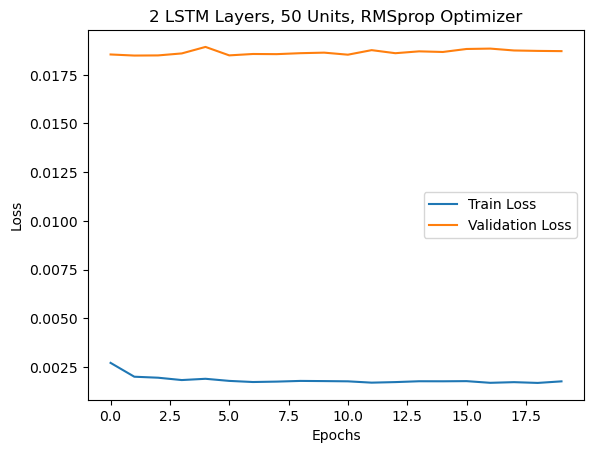

Training model with 2 LSTM layers, 50 units, using SGD optimizer...
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0027 - mae: 0.0331 - val_loss: 0.0198 - val_mae: 0.0493
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0026 - mae: 0.0287 - val_loss: 0.0198 - val_mae: 0.0492
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0018 - mae: 0.0248 - val_loss: 0.0198 - val_mae: 0.0513
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0021 - mae: 0.0253 - val_loss: 0.0198 - val_mae: 0.0513
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0021 - mae: 0.0275 - val_loss: 0.0198 - val_mae: 0.0498
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0018 - mae: 0.0270 - val_loss: 0.0198 - val_mae: 0.0512
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0020 - mae: 0.0263 - val_loss: 0.0198 - val_mae: 0.0491
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0026 - mae: 0.0272 - val_loss: 0.0198 - val_mae: 0.0

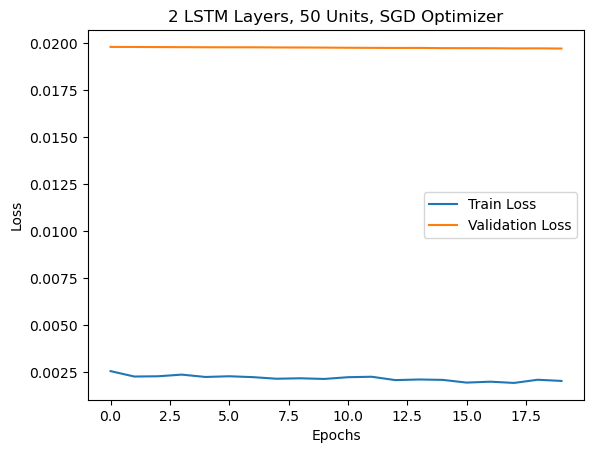

Training model with 2 LSTM layers, 64 units, using Adam optimizer...
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0042 - mae: 0.0444 - val_loss: 0.0184 - val_mae: 0.0400
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0015 - mae: 0.0186 - val_loss: 0.0183 - val_mae: 0.0446
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0017 - mae: 0.0181 - val_loss: 0.0186 - val_mae: 0.0377
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0018 - mae: 0.0155 - val_loss: 0.0186 - val_mae: 0.0347
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0011 - mae: 0.0131 - val_loss: 0.0186 - val_mae: 0.0362
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0014 - mae: 0.0149 - val_loss: 0.0186 - val_mae: 0.0335
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0014 - mae: 0.0136 - val_loss: 0.0184 - val_mae: 0.0414
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0016 - mae: 0.0163 - val_loss: 0.0186 - val_mae: 0.

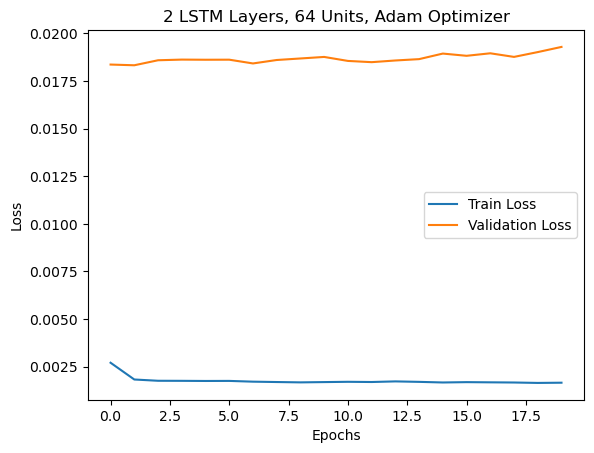

Training model with 2 LSTM layers, 64 units, using RMSprop optimizer...
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0032 - mae: 0.0358 - val_loss: 0.0192 - val_mae: 0.0362
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0013 - mae: 0.0206 - val_loss: 0.0187 - val_mae: 0.0560
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0025 - mae: 0.0217 - val_loss: 0.0187 - val_mae: 0.0580
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0019 - mae: 0.0231 - val_loss: 0.0186 - val_mae: 0.0416
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0017 - mae: 0.0182 - val_loss: 0.0187 - val_mae: 0.0548
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0017 - mae: 0.0185 - val_loss: 0.0186 - val_mae: 0.0476
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0024 - mae: 0.0190 - val_loss: 0.0187 - val_mae: 0.0416
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0019 - mae: 0.0176 - val_loss: 0.0186 - val_mae:

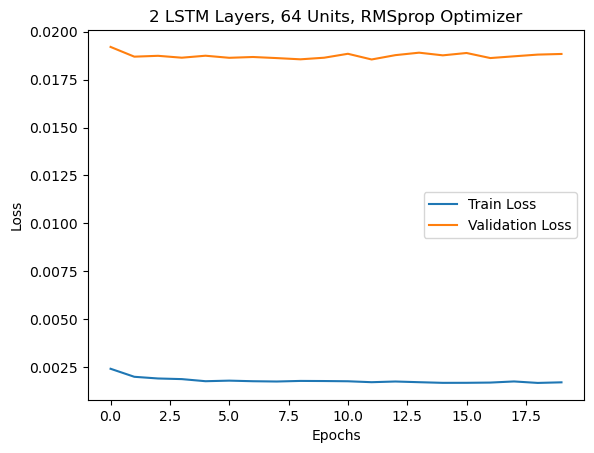

Training model with 2 LSTM layers, 64 units, using SGD optimizer...
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0035 - mae: 0.0414 - val_loss: 0.0201 - val_mae: 0.0411
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0030 - mae: 0.0272 - val_loss: 0.0196 - val_mae: 0.0393
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0018 - mae: 0.0273 - val_loss: 0.0195 - val_mae: 0.0393
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0025 - mae: 0.0281 - val_loss: 0.0194 - val_mae: 0.0396
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0025 - mae: 0.0281 - val_loss: 0.0195 - val_mae: 0.0394
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0029 - mae: 0.0284 - val_loss: 0.0195 - val_mae: 0.0393
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0018 - mae: 0.0275 - val_loss: 0.0195 - val_mae: 0.0393
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0018 - mae: 0.0245 - val_loss: 0.0193 - val_mae: 0.0

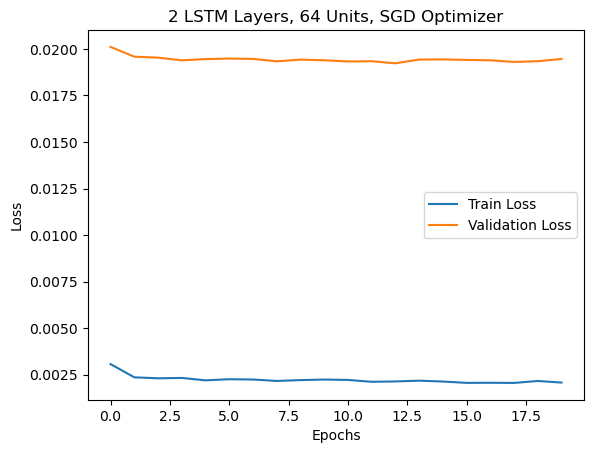

Training model with 3 LSTM layers, 32 units, using Adam optimizer...
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - loss: 0.0022 - mae: 0.0244 - val_loss: 0.0184 - val_mae: 0.0451
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0016 - mae: 0.0169 - val_loss: 0.0185 - val_mae: 0.0334
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0019 - mae: 0.0148 - val_loss: 0.0182 - val_mae: 0.0440
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0023 - mae: 0.0181 - val_loss: 0.0182 - val_mae: 0.0454
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0024 - mae: 0.0219 - val_loss: 0.0186 - val_mae: 0.0477
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0023 - mae: 0.0194 - val_loss: 0.0185 - val_mae: 0.0379
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0016 - mae: 0.0166 - val_loss: 0.0184 - val_mae: 0.0361
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0016 - mae: 0.0152 - val_loss: 0.0183 - val_mae: 0.

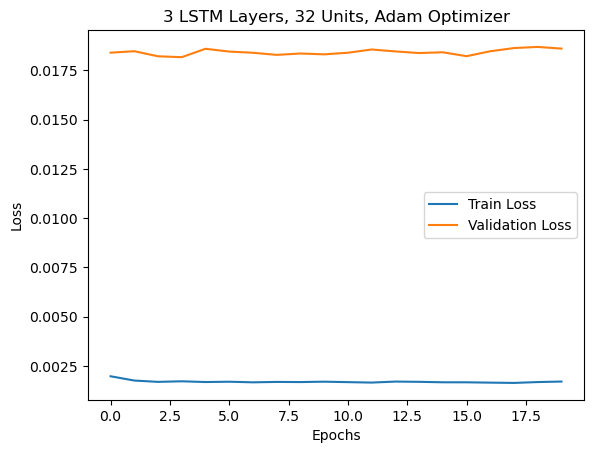

Training model with 3 LSTM layers, 32 units, using RMSprop optimizer...
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0.0046 - mae: 0.0392 - val_loss: 0.0200 - val_mae: 0.0489
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0013 - mae: 0.0205 - val_loss: 0.0192 - val_mae: 0.0460
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0023 - mae: 0.0183 - val_loss: 0.0191 - val_mae: 0.0397
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0021 - mae: 0.0193 - val_loss: 0.0187 - val_mae: 0.0433
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0017 - mae: 0.0183 - val_loss: 0.0187 - val_mae: 0.0426
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0015 - mae: 0.0171 - val_loss: 0.0188 - val_mae: 0.0369
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0025 - mae: 0.0178 - val_loss: 0.0185 - val_mae: 0.0413
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0016 - mae: 0.0168 - val_loss: 0.0185 - val_mae:

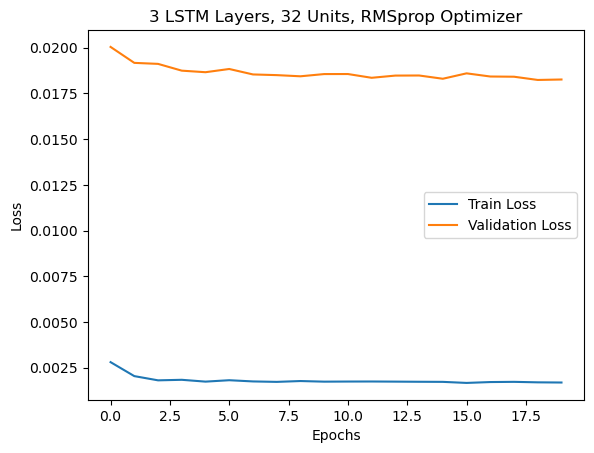

Training model with 3 LSTM layers, 32 units, using SGD optimizer...
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0020 - mae: 0.0216 - val_loss: 0.0192 - val_mae: 0.0363
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0021 - mae: 0.0190 - val_loss: 0.0191 - val_mae: 0.0360
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0018 - mae: 0.0174 - val_loss: 0.0190 - val_mae: 0.0360
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0021 - mae: 0.0188 - val_loss: 0.0189 - val_mae: 0.0362
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0014 - mae: 0.0184 - val_loss: 0.0189 - val_mae: 0.0362
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 9.7360e-04 - mae: 0.0161 - val_loss: 0.0189 - val_mae: 0.0364
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0014 - mae: 0.0177 - val_loss: 0.0189 - val_mae: 0.0362
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0014 - mae: 0.0174 - val_loss: 0.0189 - val_mae:

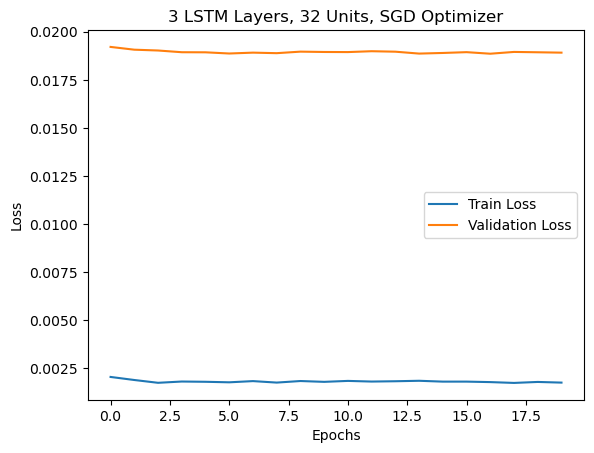

Training model with 3 LSTM layers, 50 units, using Adam optimizer...
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - loss: 0.0033 - mae: 0.0290 - val_loss: 0.0183 - val_mae: 0.0351
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 9.7217e-04 - mae: 0.0152 - val_loss: 0.0181 - val_mae: 0.0486
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0024 - mae: 0.0215 - val_loss: 0.0182 - val_mae: 0.0411
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0020 - mae: 0.0157 - val_loss: 0.0185 - val_mae: 0.0327
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0019 - mae: 0.0159 - val_loss: 0.0183 - val_mae: 0.0364
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0022 - mae: 0.0145 - val_loss: 0.0184 - val_mae: 0.0394
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0018 - mae: 0.0155 - val_loss: 0.0186 - val_mae: 0.0356
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0010 - mae: 0.0131 - val_loss: 0.0182 - val_mae

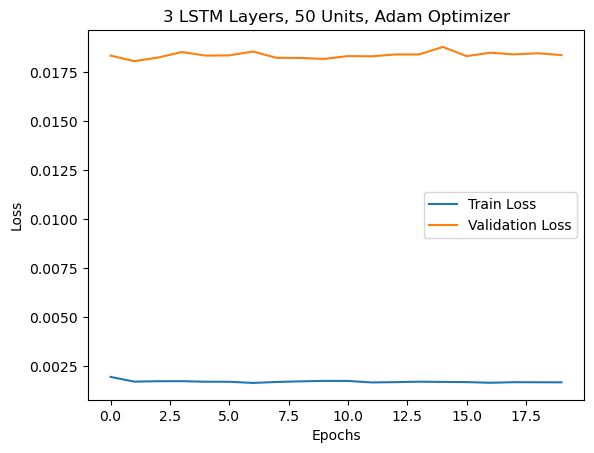

Training model with 3 LSTM layers, 50 units, using RMSprop optimizer...
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.0026 - mae: 0.0299 - val_loss: 0.0182 - val_mae: 0.0384
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0022 - mae: 0.0176 - val_loss: 0.0194 - val_mae: 0.0361
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0015 - mae: 0.0172 - val_loss: 0.0183 - val_mae: 0.0361
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0012 - mae: 0.0151 - val_loss: 0.0185 - val_mae: 0.0322
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0011 - mae: 0.0148 - val_loss: 0.0185 - val_mae: 0.0321
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 9.8622e-04 - mae: 0.0123 - val_loss: 0.0185 - val_mae: 0.0638
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0012 - mae: 0.0182 - val_loss: 0.0183 - val_mae: 0.0372
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0018 - mae: 0.0181 - val_loss: 0.0183 - val_

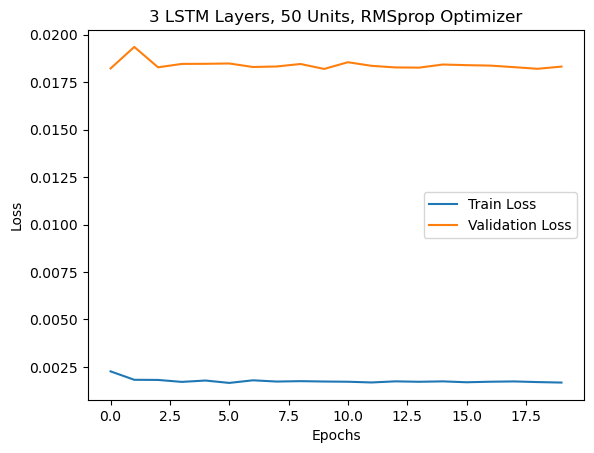

Training model with 3 LSTM layers, 50 units, using SGD optimizer...
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 0.0027 - mae: 0.0373 - val_loss: 0.0188 - val_mae: 0.0373
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0013 - mae: 0.0198 - val_loss: 0.0189 - val_mae: 0.0364
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0014 - mae: 0.0205 - val_loss: 0.0189 - val_mae: 0.0361
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0022 - mae: 0.0227 - val_loss: 0.0190 - val_mae: 0.0359
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0014 - mae: 0.0212 - val_loss: 0.0189 - val_mae: 0.0363
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0017 - mae: 0.0205 - val_loss: 0.0189 - val_mae: 0.0361
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0017 - mae: 0.0216 - val_loss: 0.0189 - val_mae: 0.0359
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0016 - mae: 0.0194 - val_loss: 0.0189 - val_mae: 0.0

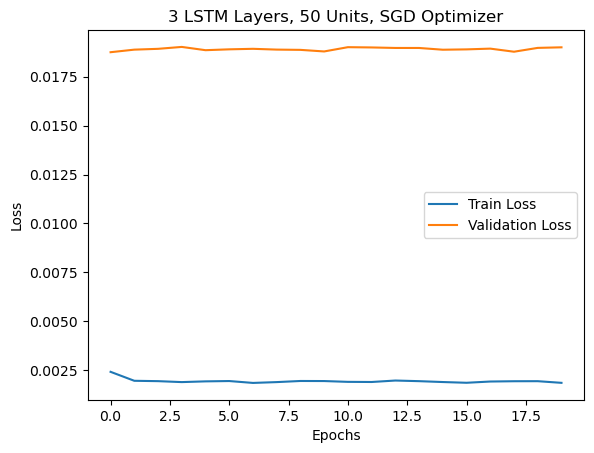

Training model with 3 LSTM layers, 64 units, using Adam optimizer...
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - loss: 0.0028 - mae: 0.0374 - val_loss: 0.0187 - val_mae: 0.0294
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0017 - mae: 0.0150 - val_loss: 0.0185 - val_mae: 0.0327
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0020 - mae: 0.0162 - val_loss: 0.0186 - val_mae: 0.0312
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0032 - mae: 0.0198 - val_loss: 0.0184 - val_mae: 0.0321
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0020 - mae: 0.0142 - val_loss: 0.0184 - val_mae: 0.0344
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0018 - mae: 0.0155 - val_loss: 0.0188 - val_mae: 0.0328
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0012 - mae: 0.0131 - val_loss: 0.0183 - val_mae: 0.0392
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0024 - mae: 0.0175 - val_loss: 0.0183 - val_mae: 0.

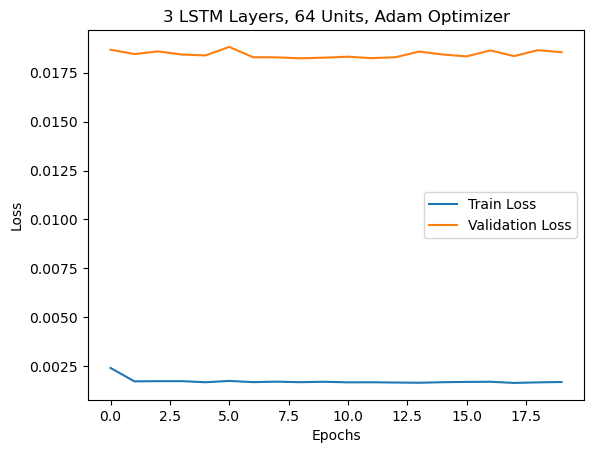

Training model with 3 LSTM layers, 64 units, using RMSprop optimizer...
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0027 - mae: 0.0294 - val_loss: 0.0187 - val_mae: 0.0371
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0033 - mae: 0.0213 - val_loss: 0.0187 - val_mae: 0.0337
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0016 - mae: 0.0155 - val_loss: 0.0186 - val_mae: 0.0333
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0013 - mae: 0.0144 - val_loss: 0.0183 - val_mae: 0.0450
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0015 - mae: 0.0157 - val_loss: 0.0185 - val_mae: 0.0333
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0012 - mae: 0.0155 - val_loss: 0.0183 - val_mae: 0.0558
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0013 - mae: 0.0151 - val_loss: 0.0186 - val_mae: 0.0336
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0019 - mae: 0.0152 - val_loss: 0.0183 - val_mae:

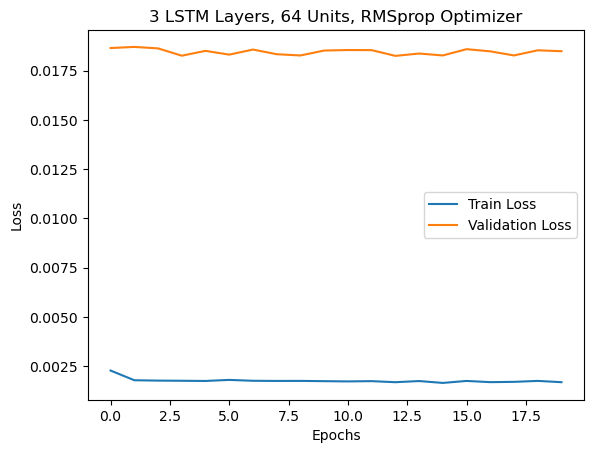

Training model with 3 LSTM layers, 64 units, using SGD optimizer...
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.0022 - mae: 0.0198 - val_loss: 0.0186 - val_mae: 0.0353
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0012 - mae: 0.0191 - val_loss: 0.0185 - val_mae: 0.0362
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0026 - mae: 0.0205 - val_loss: 0.0186 - val_mae: 0.0358
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0018 - mae: 0.0212 - val_loss: 0.0186 - val_mae: 0.0356
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0018 - mae: 0.0195 - val_loss: 0.0186 - val_mae: 0.0355
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0030 - mae: 0.0233 - val_loss: 0.0186 - val_mae: 0.0353
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0010 - mae: 0.0167 - val_loss: 0.0185 - val_mae: 0.0360
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0017 - mae: 0.0200 - val_loss: 0.0186 - val_mae: 0.0

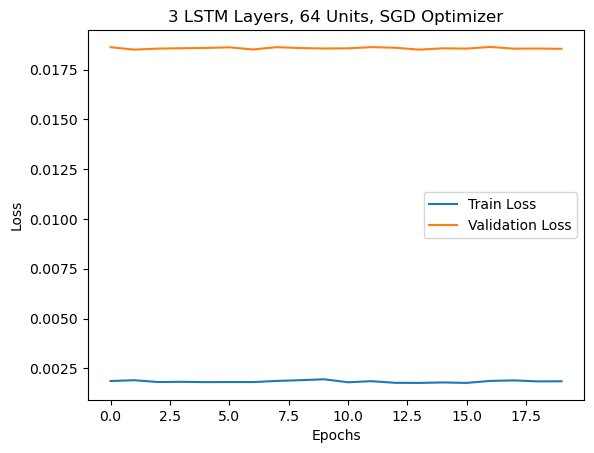

    layers  units optimizer  train_loss  test_loss  train_mae  test_mae
0        1     32      Adam    0.001619   0.019587   0.015164  0.046523
1        1     32   RMSprop    0.001643   0.019265   0.018728  0.051675
2        1     32       SGD    0.001661   0.022418   0.015061  0.061628
3        1     50      Adam    0.001615   0.019092   0.013967  0.043418
4        1     50   RMSprop    0.001667   0.018806   0.010460  0.036308
5        1     50       SGD    0.001691   0.018672   0.015711  0.046243
6        1     64      Adam    0.001616   0.019658   0.016020  0.048401
7        1     64   RMSprop    0.001655   0.019426   0.010774  0.042053
8        1     64       SGD    0.001693   0.017662   0.015350  0.036260
9        2     32      Adam    0.001630   0.019156   0.012094  0.038651
10       2     32   RMSprop    0.001631   0.018492   0.015563  0.040913
11       2     32       SGD    0.001749   0.020743   0.016817  0.050240
12       2     50      Adam    0.001626   0.019008   0.012725  0

In [11]:
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.backend import clear_session
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define configurations for comparison
layer_configs = [1, 2, 3]  # Different numbers of LSTM layers
optimizer_classes = {'Adam': Adam, 'RMSprop': RMSprop, 'SGD': SGD}  # Optimizer classes
units_configs = [32, 50, 64]  # Different numbers of LSTM units per layer

# Results storage
results = []

# Iterate over configurations
for num_layers in layer_configs:
    for units in units_configs:
        for opt_name, optimizer_class in optimizer_classes.items():
            print(f"Training model with {num_layers} LSTM layers, {units} units, using {opt_name} optimizer...")
            
            # Reset TensorFlow session to clear graph state
            clear_session()
            
            # Ensure data types are compatible
            X_train = X_train.astype(np.float32)
            y_train = y_train.astype(np.float32)
            X_test = X_test.astype(np.float32)
            y_test = y_test.astype(np.float32)

            # Create a new optimizer instance
            optimizer = optimizer_class()

            # Build the model
            model = build_lstm_model(input_shape=(look_back, len(features)), num_layers=num_layers, units=units)

            try:
                # Train and evaluate the model
                trained_model, history = train_and_evaluate_model(model, optimizer, X_train, y_train, X_test, y_test)
                
                # Evaluate performance
                train_loss, train_mae = trained_model.evaluate(X_train, y_train, verbose=0)
                test_loss, test_mae = trained_model.evaluate(X_test, y_test, verbose=0)
                
                # Store results
                results.append({
                    'layers': num_layers,
                    'units': units,
                    'optimizer': opt_name,
                    'train_loss': train_loss,
                    'test_loss': test_loss,
                    'train_mae': train_mae,
                    'test_mae': test_mae
                })

                # Plot training vs validation loss
                plt.plot(history.history['loss'], label='Train Loss')
                plt.plot(history.history['val_loss'], label='Validation Loss')
                plt.title(f'{num_layers} LSTM Layers, {units} Units, {opt_name} Optimizer')
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.legend()
                plt.show()

            except Exception as e:
                print(f"Error encountered during training with {num_layers} layers, {units} units, {opt_name} optimizer.")
                print(f"Error: {str(e)}")
                continue

# Save and display results
results_df = pd.DataFrame(results)
print(results_df)


In [12]:
# Reload the original dataset
df_original = pd.read_csv(r"C:\Users\souvick\Downloads\Bitcoin - dataset.csv")

# Refit the target scaler on the original (unscaled) target
target_scaler = MinMaxScaler()
target_scaler.fit(df_original[['close']])

# Optional: Debugging - Check the scaler's fitted range
print(f"Target Scaler Data Range: Min={target_scaler.data_min_[0]}, Max={target_scaler.data_max_[0]}")


Target Scaler Data Range: Min=8.29e-11, Max=67566.83009


In [13]:
def predict_future(data, model, look_back, feature_scaler, target_scaler):
    # Ensure the input data has the correct number of features
    if data.shape[1] != len(features):
        raise ValueError(f"Input data must have {len(features)} features, but got {data.shape[1]}.")

    # Scale the input features
    data_scaled = feature_scaler.transform(data)

    # Prepare the last `look_back` rows for prediction
    sequence = data_scaled[-look_back:]  # Shape: (look_back, num_features)
    sequence = np.expand_dims(sequence, axis=0)  # Shape: (1, look_back, num_features)

    # Predict using the model
    prediction_scaled = model.predict(sequence)  # Shape: (1, 1)

    # Inverse transform the scaled prediction to the original scale
    prediction_original = target_scaler.inverse_transform(prediction_scaled)

    return prediction_original[0, 0]  # Return the scalar prediction


In [14]:
from sklearn.preprocessing import MinMaxScaler

# Initialize and fit feature scaler
feature_scaler = MinMaxScaler()
df_sample[features] = feature_scaler.fit_transform(df_sample[features])


In [15]:
next_price = predict_future(
    data=df_sample[features].values,  # Pass the feature values
    model=model,                      # Trained LSTM model
    look_back=look_back,              # Number of past timesteps
    feature_scaler=feature_scaler,    # Feature scaler
    target_scaler=target_scaler       # Correctly fitted target scaler
)

print(f"Predicted Next Close Price: {next_price:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
Predicted Next Close Price: 293.70


In [16]:
def generate_data_statistics(df):
    import pandas as pd
    from scipy.stats import kurtosis, skew

    # Prepare a list to store statistics
    stats = []

    for col in df.columns:
        col_data = df[col]
        col_stats = {
            'Column': col,
            'Data Type': col_data.dtype,
            'Unique Values': col_data.nunique(),
            'Missing Values': col_data.isnull().sum(),
            '% Missing': round((col_data.isnull().sum() / len(col_data)) * 100, 2),
        }

        if col_data.dtype in ['float64', 'int64']:  # Numeric columns
            col_stats.update({
                'Mean': round(col_data.mean(), 4),
                'Median': round(col_data.median(), 4),
                'Std Dev': round(col_data.std(), 4),
                'Min': round(col_data.min(), 4),
                'Max': round(col_data.max(), 4),
                'Skewness': round(skew(col_data.dropna()), 4),
                'Kurtosis': round(kurtosis(col_data.dropna()), 4),
                'Top': 'N/A',  # Not applicable for numeric
                'Frequency': 'N/A'
            })
        else:  # Categorical or Object columns
            top_value = col_data.mode().iloc[0] if not col_data.mode().empty else None
            top_freq = col_data.value_counts().iloc[0] if not col_data.value_counts().empty else None
            col_stats.update({
                'Mean': 'N/A',
                'Median': 'N/A',
                'Std Dev': 'N/A',
                'Min': 'N/A',
                'Max': 'N/A',
                'Skewness': 'N/A',
                'Kurtosis': 'N/A',
                'Top': top_value,
                'Frequency': top_freq
            })

        stats.append(col_stats)

    # Convert list of stats into a DataFrame
    return pd.DataFrame(stats)

# Generate data statistics for the sample DataFrame
data_statistics = generate_data_statistics(df_sample)

# Display the result
print(data_statistics)


         Column Data Type  Unique Values  Missing Values  % Missing    Mean  \
0          open   float64            993               0        0.0  0.0157   
1          high   float64            992               0        0.0   0.016   
2           low   float64            993               0        0.0  0.0162   
3         close   float64            992               0        0.0  0.0164   
4        volume   float64            997               0        0.0  0.0149   
5     marketCap   float64            974               0        0.0  0.0134   
6     timestamp    object            796               0        0.0     N/A   
7   crypto_name    object             54               0        0.0     N/A   
8          date    object            796               0        0.0     N/A   
9      7_day_MA   float64            995               0        0.0  0.0397   
10    30_day_MA   float64            972               0        0.0  0.1242   
11   price_diff   float64            998            

In [17]:
import pandas as pd
from scipy.stats import skew
from IPython.display import display

def feature_statistics(df, features):
    """
    Generates a feature-wise statistical analysis.
    """
    stats = pd.DataFrame(index=features)
    stats['Min'] = df[features].min()
    stats['Max'] = df[features].max()
    stats['Range'] = stats['Max'] - stats['Min']
    stats['Mean'] = df[features].mean()
    stats['Median'] = df[features].median()
    stats['Std Dev'] = df[features].std()
    stats['Skewness'] = df[features].apply(skew)
    return stats

# Assuming df_sample and features are defined
feature_stats_df = feature_statistics(df_sample, features)

# Display statistics
display(feature_stats_df)

,Min,Max,Range,Mean,Median,Std Dev,Skewness
open,0.0,1.0,1.0,0.015679,0.000028,0.090853,8.112457
high,0.0,1.0,1.0,0.016000,0.000029,0.092526,8.070499
low,0.0,1.0,1.0,0.016214,0.000029,0.093999,8.098423
volume,0.0,1.0,1.0,0.014942,0.000816,0.062945,8.194901
marketCap,0.0,1.0,1.0,0.013357,0.001176,0.064637,9.304808
7_day_MA,0.0,1.0,1.0,0.039662,0.003215,0.106890,5.296864
30_day_MA,0.0,1.0,1.0,0.124179,0.050069,0.194910,2.759963
price_diff,0.0,1.0,1.0,0.499921,0.499921,0.063861,-0.083150
volatility,0.0,1.0,1.0,0.058509,0.043653,0.067992,7.227551


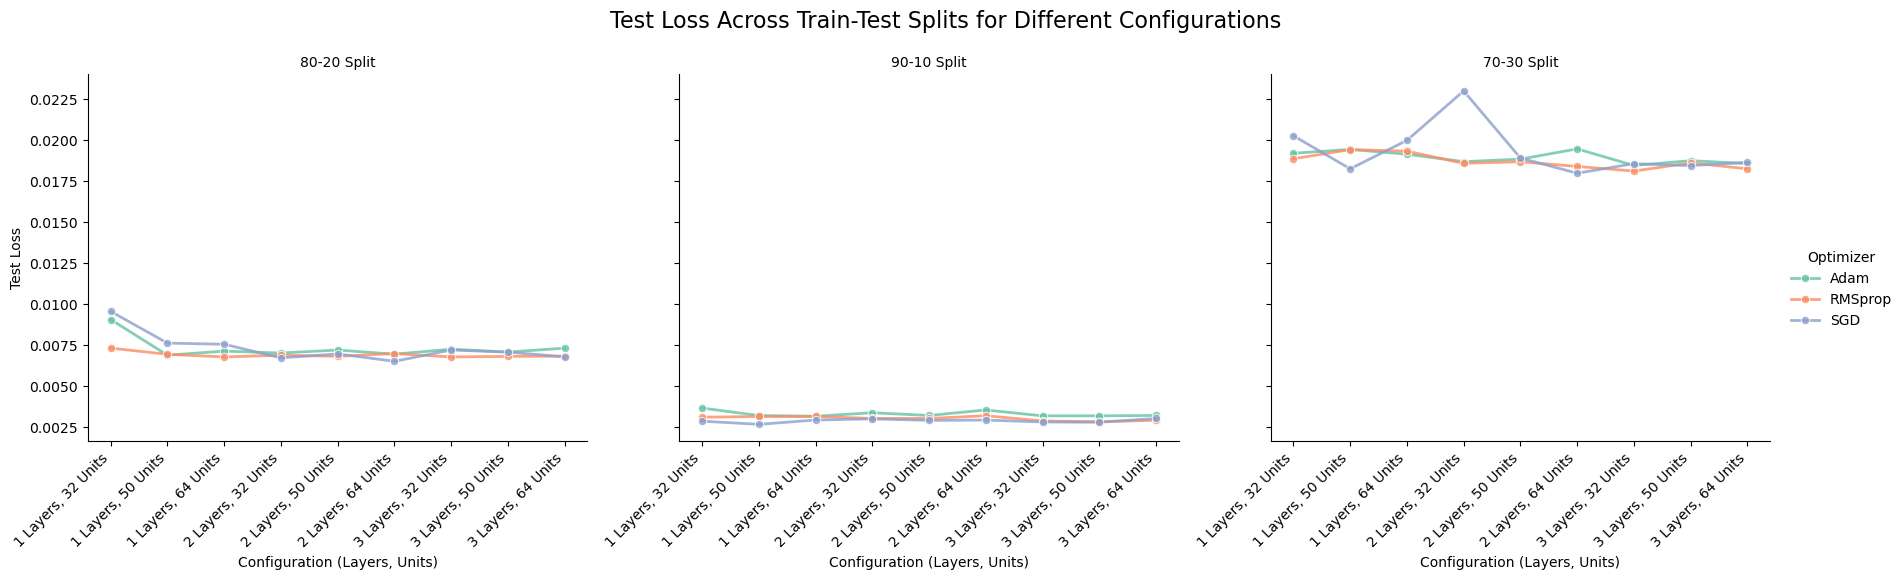

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the data from your results
data = {
    "Split": ["80-20"] * 27 + ["90-10"] * 27 + ["70-30"] * 27,
    "Layers": [1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3] * 3,
    "Units": [32, 32, 32, 50, 50, 50, 64, 64, 64] * 9,
    "Optimizer": ["Adam", "RMSprop", "SGD"] * 27,
    "Test Loss": [
        # 80-20 split results
        0.009052, 0.007313, 0.009546, 0.006882, 0.006934, 0.007618, 
        0.007129, 0.006776, 0.007547, 0.007014, 0.006883, 0.006718, 
        0.007196, 0.006811, 0.006960, 0.006943, 0.006981, 0.006509, 
        0.007247, 0.006774, 0.007197, 0.007071, 0.006808, 0.007067, 
        0.007310, 0.006822, 0.006784,
        # 90-10 split results
        0.003664, 0.003105, 0.002865, 0.003208, 0.003151, 0.002673, 
        0.003164, 0.003150, 0.002934, 0.003379, 0.003030, 0.003006, 
        0.003211, 0.003031, 0.002912, 0.003547, 0.003197, 0.002931, 
        0.003188, 0.002878, 0.002815, 0.003189, 0.002830, 0.002800, 
        0.003213, 0.002919, 0.003029,
        # 70-30 split results
        0.019173, 0.018838, 0.020236, 0.019409, 0.019397, 0.018229, 
        0.019115, 0.019301, 0.019959, 0.018663, 0.018563, 0.022968, 
        0.018816, 0.018656, 0.018882, 0.019441, 0.018373, 0.017960, 
        0.018431, 0.018090, 0.018542, 0.018723, 0.018588, 0.018424, 
        0.018547, 0.018229, 0.018619
    ]
}

# Create the DataFrame
df = pd.DataFrame(data)

# Add a new column for configuration (layers + units)
df["Config"] = df["Layers"].astype(str) + " Layers, " + df["Units"].astype(str) + " Units"

# Create the FacetGrid for visualization
g = sns.FacetGrid(
    df, col="Split", hue="Optimizer", palette="Set2", height=5, aspect=1.2
)
g.map(
    sns.lineplot, "Config", "Test Loss", marker="o", linewidth=2, alpha=0.8
).add_legend()

# Adjust titles, labels, and layout
g.set_titles("{col_name} Split")
g.set_axis_labels("Configuration (Layers, Units)", "Test Loss")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Test Loss Across Train-Test Splits for Different Configurations", fontsize=16)

# Rotate x-axis labels for readability
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')

# Show the plot
plt.show()


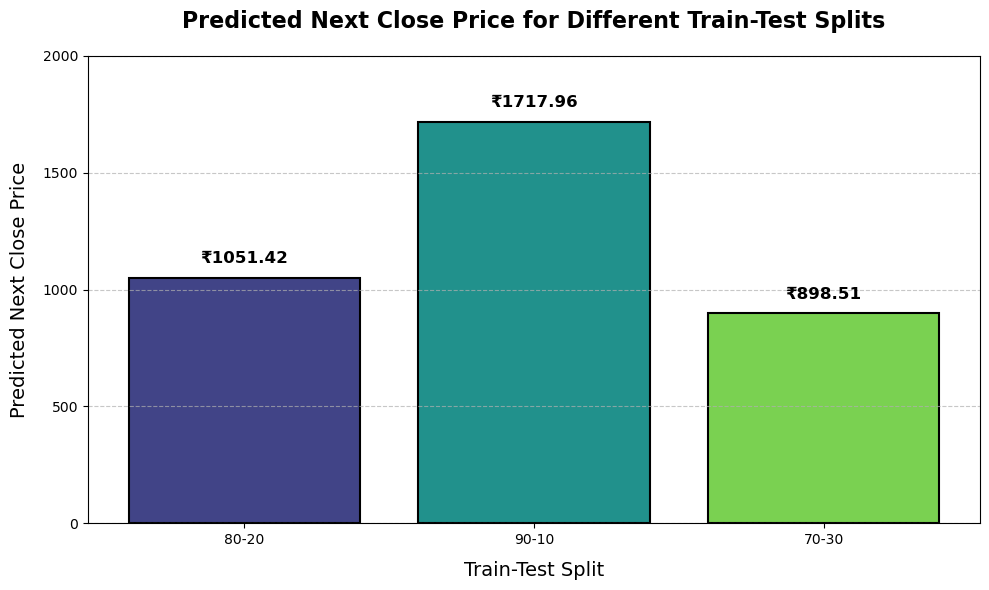

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Predicted Next Close Prices
predicted_next_close_prices = {
    "80-20": 1051.42,
    "90-10": 1717.96,
    "70-30": 898.51
}

splits = list(predicted_next_close_prices.keys())
prices = list(predicted_next_close_prices.values())

# Gradient coloring based on price values
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(prices)))

plt.figure(figsize=(10, 6))
bars = plt.bar(splits, prices, color=colors, edgecolor="black", linewidth=1.5)

# Add exact price annotations
for bar, price in zip(bars, prices):
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        bar.get_height() + 50, 
        f"₹{price:.2f}", 
        ha="center", 
        va="bottom", 
        fontsize=12, 
        fontweight="bold"
    )

# Add dynamic y-ticks for clarity
plt.yticks(np.arange(0, max(prices) + 500, 500), fontsize=10)

# Title and labels
plt.title("Predicted Next Close Price for Different Train-Test Splits", fontsize=16, fontweight="bold", pad=20)
plt.xlabel("Train-Test Split", fontsize=14, labelpad=10)
plt.ylabel("Predicted Next Close Price", fontsize=14, labelpad=10)

# Add a grid for better readability
plt.grid(axis='y', linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()
